In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
from RateTraining import *

<>:24: SyntaxWarning: invalid escape sequence '\o'
<>:24: SyntaxWarning: invalid escape sequence '\o'
C:\Users\lab\AppData\Local\Temp\ipykernel_10364\2489711867.py:24: SyntaxWarning: invalid escape sequence '\o'
  labels = ['$\omega (t)$', '$f_{in}$', '$f_{hint}$', '$f_{out}$']


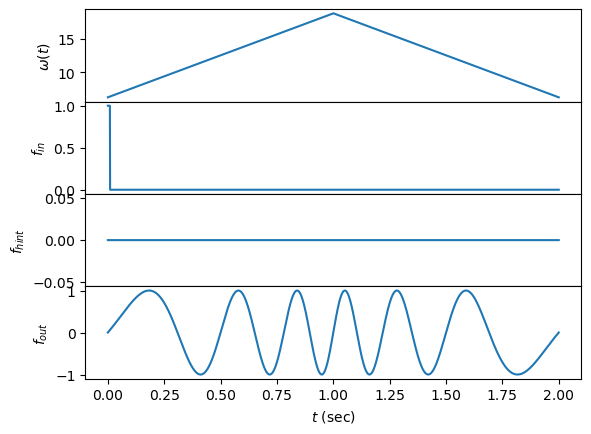

In [4]:
def inps_and_targs(dt, plot=False):
    t = np.linspace(0, 2, int(1./dt))
    
    omega = np.zeros(t.shape)
    omega[:int(t.shape[0]/2)] = np.linspace(2*np.pi, 6*np.pi, int(t.shape[0]/2))
    omega[int(t.shape[0]/2):] = np.flipud(omega[:int(t.shape[0]/2)]) # increasing decreasing (frequency of sin in fout)
    
    fout = np.zeros(t.shape)
    fout[:int(t.shape[0]/2)] = np.sin(omega[:int(t.shape[0]/2)] * t[:int(t.shape[0]/2)])
    fout[int(t.shape[0]/2):] = -np.flipud(fout[:int(t.shape[0]/2)])

    fhint = np.zeros(t.shape)

    fin = np.zeros(t.shape)
    fin[:10] = np.ones(10)

    fin = np.reshape(fin, (1, fin.size)).T
    fout = np.reshape(fout, (1, fout.size)).T
    fhint = np.reshape(fhint, (1, fhint.size)).T

    if plot:
        fig, axs = plt.subplots(4, 1, sharex=True)
        plt.subplots_adjust(hspace=0)
        labels = ['$\omega (t)$', '$f_{in}$', '$f_{hint}$', '$f_{out}$']
        for ax, y, label in zip(axs, [omega, fin, fhint, fout], labels):
            ax.plot(t, y)
            ax.set_ylabel(label)
        axs[-1].set_xlabel('$t$ (sec)')

    return (fin, fout, fhint)

dt = 0.0005 # 1/dt total timesteps
fin, fout, _ = inps_and_targs(dt, plot=True)

In [15]:
np.shape(fout)

(2000, 1)

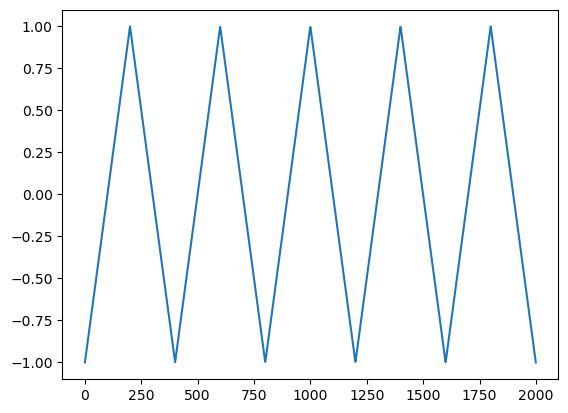

In [17]:
t = np.linspace(0, 2, 2000)
sawtarg = sp.signal.sawtooth(5 * np.pi * t, 0.5)
sawtarg = sawtarg[:, np.newaxis]
plt.plot(sawtarg)

In [18]:
np.shape(sawtarg)

(2000, 1)

In [19]:
npar, tpar, trpar, cpar, rpar = create_default_params_rate()
tpar['dt'] = 1
tpar['total_time'] = 2000
rpar['run_time'] = 2000
trpar['training_loops'] = 200

### built in fullFORCE

In [20]:
net = RateTraining(npar, tpar, trpar, cpar, rpar)

In [21]:
xt, Hxt, errs, rel_errs, aux_targs, ufin, ufout = net.fullFORCE(fin, sawtarg)

Stabilizing networks
100 total trainings
training: 0
training: 20
training: 40
training: 60
training: 80


Text(0.5, 1.0, 'Sample task-generating internal behavior')

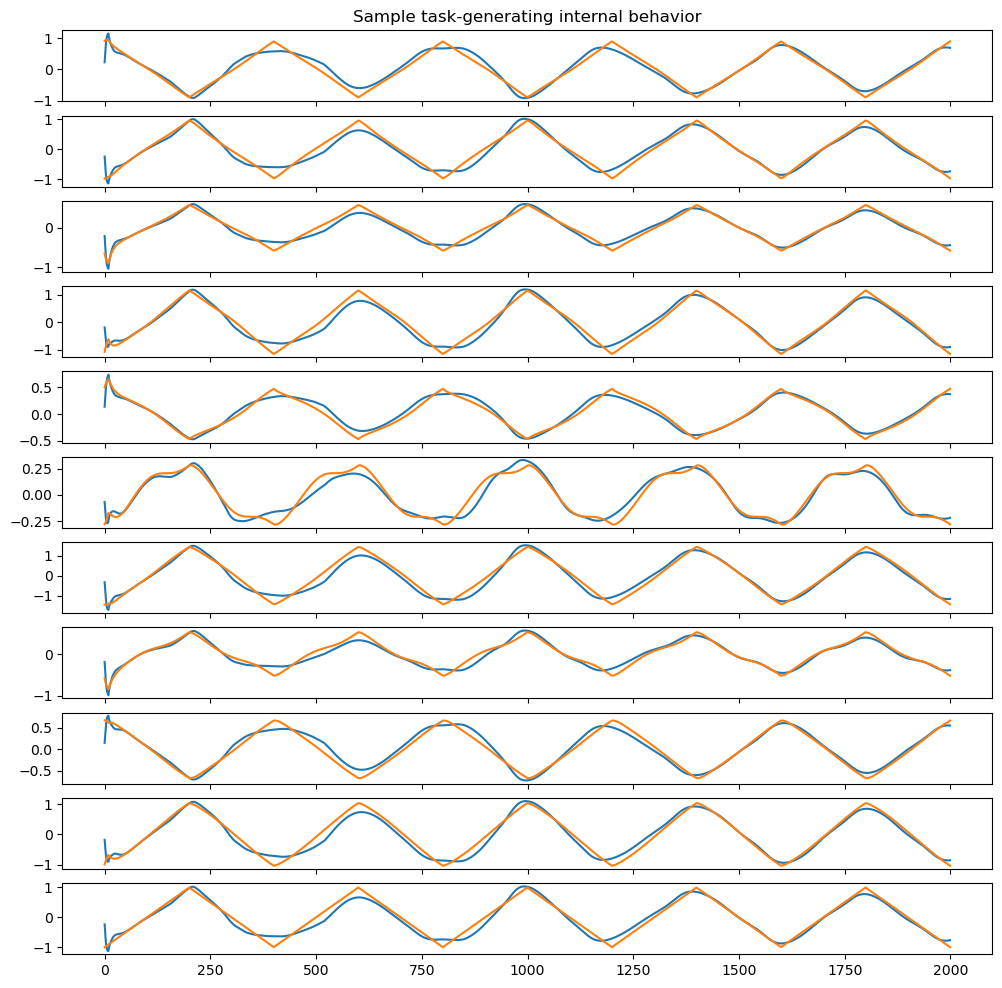

In [23]:
n_plot = 10
nloop = trpar['training_loops']
timesteps = int(tpar['total_time']/tpar['dt'])
btp = 0

zt = np.dot(net.W_trained, Hxt)

fig, axs = plt.subplots(n_plot + 1, 1, figsize = (12, 12), sharex = True)
for i in range(n_plot):
    # axs[i].plot(Hxt[i, 0:timesteps])
    # axs[i].plot(aux_targs[i, 0:timesteps])
    axs[i].plot(zt[i, (btp)*timesteps:(btp + 1)*timesteps])
    axs[i].plot(aux_targs[i, (btp)*timesteps:(btp + 1)*timesteps])

axs[n_plot].plot(net.W_out @ Hxt[:, (btp)*timesteps:(btp + 1)*timesteps])
axs[n_plot].plot(sawtarg)

axs[0].set_title("Sample task-generating internal behavior")

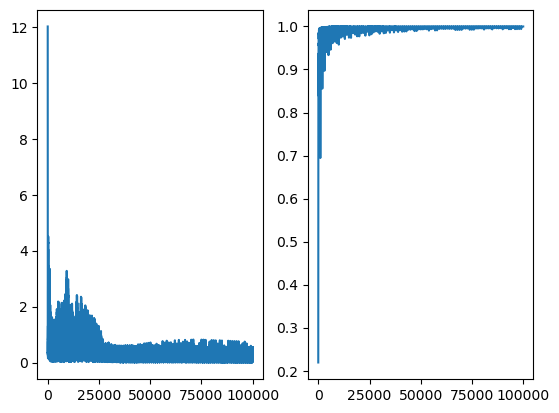

In [24]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(errs)
axs[1].plot(rel_errs)

In [25]:
x, Hx = net.run_rate(ufin)

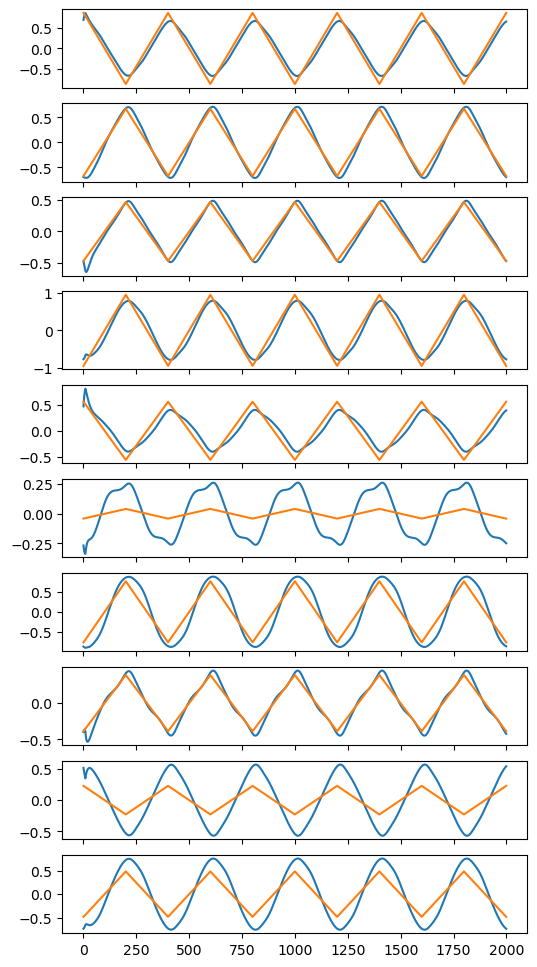

In [27]:
n_plot = 10
nloop = net.nloop
timesteps = int(net.run_time / net.dt)

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Hx[i])
    axs[i].plot(ufout[i])
